# Clustering on Open Food Facts dataset

### Load data

In [1]:
# Imports libraries
import pandas as pd
import numpy as np
# import mlflow
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# import umap
%matplotlib inline
import matplotlib.pyplot as plt

from scripts import analyse_columns, clean
from scripts.kmeans import kmeans_clustering, plot_elbow_method
from scripts.plots import plot_clusters_2d, plot_cluster_sizes, plot_feature_relationships
from scripts.model_utils import load_model
from scripts.autoencoder import autoencoder_clustering, plot_autoencoder_advanced_analysis, analyze_encoding_dimensions
from scripts.kmeans import kmeans_clustering
# from scripts.dimension_reduction import reduce_dimensions

# mlflow.autolog()

Matplotlib successfully imported with inline backend


In [2]:
# Load Open Food Facts dataset csv
path = "data/en.openfoodfacts.org.products.csv"

df = pd.read_csv(path, 
                 sep='\\t', 
                 encoding="utf-8",
                 on_bad_lines='skip',
                 nrows=300000)

C:\Users\jaech\AppData\Local\Temp\ipykernel_10800\4190858480.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(path,


In [3]:
# Display basic information about the dataset
print("\nFirst few rows:")
display(df.head())


First few rows:


,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,last_modified_by,last_updated_t,last_updated_datetime,...,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g,sulphate_100g,nitrate_100g,acidity_100g
0,54,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1582569031,2020-02-24T18:30:31Z,1733085204,2024-12-01T20:33:24Z,NaN,1.740205e+09,2025-02-22T06:23:42Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,63,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1673620307,2023-01-13T14:31:47Z,1739902555,2025-02-18T18:15:55Z,waistline-app,1.743267e+09,2025-03-29T16:49:10Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,114,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1580066482,2020-01-26T19:21:22Z,1737247862,2025-01-19T00:51:02Z,smoothie-app,1.743312e+09,2025-03-30T05:22:25Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,http://world-en.openfoodfacts.org/product/0000...,inf,1634745456,2021-10-20T15:57:36Z,1743233868,2025-03-29T07:37:48Z,smoothie-app,1.743281e+09,2025-03-29T20:48:12Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,105,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1572117743,2019-10-26T19:22:23Z,1738073570,2025-01-28T14:12:50Z,NaN,1.740085e+09,2025-02-20T20:57:12Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Display number of rows and columns
print(df.shape)

(300000, 207)


In [5]:
# Show summary statistics of numeric columns
# Display detailed summary statistics of numeric columns
print("\nSummary statistics of numeric columns:")
print(df.describe(include=[np.number], percentiles=[.05, .25, .5, .75, .95]))

# Show additional statistics
print("\nSkewness of numeric columns:")
print(df.select_dtypes(include=[np.number]).skew())

print("\nKurtosis of numeric columns:")
print(df.select_dtypes(include=[np.number]).kurtosis())

# Count number of non-null values for each numeric column
print("\nNumber of non-null values in numeric columns:")
print(df.select_dtypes(include=[np.number]).count())


Summary statistics of numeric columns:
               code     created_t  last_modified_t  last_updated_t  cities  \
count  3.000000e+05  3.000000e+05     3.000000e+05    2.999990e+05     0.0   
mean   3.137336e+10  1.602221e+09     1.675281e+09    1.730084e+09     NaN   
std    1.790903e+10  7.941908e+07     6.019029e+07    1.264524e+07     NaN   
min    1.000000e+00  1.332445e+09     1.424628e+09    1.701775e+09     NaN   
5%     3.751437e+05  1.489060e+09     1.587584e+09    1.707823e+09     NaN   
25%    1.586902e+10  1.537557e+09     1.627337e+09    1.720854e+09     NaN   
50%    3.582620e+10  1.592158e+09     1.686268e+09    1.734786e+09     NaN   
75%    4.222213e+10  1.660326e+09     1.728055e+09    1.738831e+09     NaN   
95%    5.974993e+10  1.726980e+09     1.740369e+09    1.742519e+09     NaN   
max    6.263936e+10  1.743488e+09     1.743488e+09    1.743488e+09     NaN   

       allergens_en  serving_quantity    additives_n  additives  \
count           0.0      1.740800e

### Data Processing

In [6]:
# Keep only relevant columns (nutritional columns)

# Define features to keep
features = [
    'energy-kcal_100g', 'energy_100g',
    'fat_100g', 'saturated-fat_100g',
    'carbohydrates_100g', 'sugars_100g', 
    'fiber_100g', 'proteins_100g',
    'salt_100g', 'sodium_100g',
    'fruits-vegetables-nuts-estimate-from-ingredients_100g',
    'additives_n',
    'nova_group'  # optional but relevant
]
# Update irrelevant_columns to be columns not in features
irrelevant_columns = [col for col in df.columns if col not in features]

# Manually remove energy-kcal_100g and fat_100g from irrelevant_columns
# irrelevant_columns.extend(['energy-kcal_100g', 'fat_100g'])


# Clean dataset using the clean() function
df_cleaned = clean.clean(df, irrelevant_columns=irrelevant_columns, missing_threshold=0.5)

# Display cleaned dataset info
print("\nCleaned dataset shape:", df.shape)
print("\nRemaining columns:")
print(df_cleaned.columns.tolist())



Cleaned dataset shape: (300000, 207)

Remaining columns:
['additives_n', 'nova_group', 'energy-kcal_100g', 'energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'fruits-vegetables-nuts-estimate-from-ingredients_100g']


In [7]:
# Handle missing values by filling with median for numeric columns
# Using median instead of mean to be more robust to outliers
df_cleaned = df_cleaned.fillna(df_cleaned.median())

# Verify no more NaN values exist
print("\nNumber of NaN values remaining:")
print(df_cleaned.isna().sum().sum())

# Display first few rows to verify changes
print("\nFirst few rows after handling missing values:")
display(df_cleaned.head())

print("\nShape")
print(df_cleaned.shape)


Number of NaN values remaining:
0

First few rows after handling missing values:


,additives_n,nova_group,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g
0,1.0,4.0,270.0,1130.0,5.177877,1.5,23.0,5.263158,1.41,5.0,0.435,0.174,0.670268
1,0.0,4.0,332.0,1389.0,25.000000,17.3,3.0,1.000000,1.41,23.0,1.200,0.480,0.000000
2,1.0,4.0,270.0,2415.0,44.000000,28.0,30.0,27.000000,1.41,7.1,0.025,0.010,0.670268
3,0.0,1.0,270.0,1130.0,5.177877,1.5,23.0,5.263158,1.41,5.0,0.435,0.174,100.000000
4,2.0,4.0,270.0,1130.0,5.177877,1.5,23.0,5.263158,1.41,5.0,0.435,0.174,0.011335



Shape
(300000, 13)


In [8]:
# Scale features using StandardScaler
scaler = StandardScaler()
df_scaled = pd.DataFrame(
    scaler.fit_transform(df_cleaned),
    columns=df_cleaned.columns
)

# Display first few rows of scaled data
print("First few rows of scaled data:")
display(df_scaled.head())

# Verify scaling - mean should be ~0 and std should be ~1
print("\nMean of scaled features:")
print(df_scaled.mean().round(2))
print("\nStandard deviation of scaled features:")
print(df_scaled.std().round(2))

First few rows of scaled data:


,additives_n,nova_group,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g
0,-0.330879,0.358727,-0.132840,-0.132443,-0.234240,-0.128699,-0.241186,-0.276767,-0.061343,-0.167041,-0.001826,-0.001826,-0.397388
1,-0.737285,0.358727,-0.014134,-0.013832,0.228137,0.449043,-0.540719,-0.378831,-0.061343,0.625166,-0.001826,-0.001826,-0.425239
2,-0.330879,0.358727,-0.132840,0.456029,0.671337,0.840298,-0.136349,0.243635,-0.061343,-0.074617,-0.001826,-0.001826,-0.397388
3,-0.737285,-3.765469,-0.132840,-0.132443,-0.234240,-0.128699,-0.241186,-0.276767,-0.061343,-0.167041,-0.001826,-0.001826,3.730039
4,0.075528,0.358727,-0.132840,-0.132443,-0.234240,-0.128699,-0.241186,-0.276767,-0.061343,-0.167041,-0.001826,-0.001826,-0.424768



Mean of scaled features:
additives_n                                             -0.0
nova_group                                               0.0
energy-kcal_100g                                         0.0
energy_100g                                             -0.0
fat_100g                                                -0.0
saturated-fat_100g                                       0.0
carbohydrates_100g                                      -0.0
sugars_100g                                              0.0
fiber_100g                                              -0.0
proteins_100g                                           -0.0
salt_100g                                                0.0
sodium_100g                                             -0.0
fruits-vegetables-nuts-estimate-from-ingredients_100g   -0.0
dtype: float64

Standard deviation of scaled features:
additives_n                                              1.0
nova_group                                               1.0
ener

In [9]:
# Remove outliers using IQR method
def remove_outliers(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    
    # Define bounds
    lower_bound = Q1 - 1.5 * IQR 
    upper_bound = Q3 + 1.5 * IQR
    
    # Create mask for values within bounds
    mask = ~((df < lower_bound) | (df > upper_bound)).any(axis=1)
    
    return df[mask]

# Remove outliers and store in new DataFrame
print("Shape before removing outliers:", df_scaled.shape)
df_scaled_no_outliers = remove_outliers(df_scaled)
print("Shape after removing outliers:", df_scaled_no_outliers.shape)
print(f"Removed {df_scaled.shape[0] - df_scaled_no_outliers.shape[0]} outliers")

# Update original data without outliers for consistency
df_cleaned = df_cleaned.loc[df_scaled_no_outliers.index]

Shape before removing outliers: (300000, 13)
Shape after removing outliers: (117423, 13)
Removed 182577 outliers


### Feature Engineering

In [12]:
# Create new features


In [ ]:
# Take a smaller sample for visualization (10,000 rows)
sample_size = 10000
print(f"Taking a sample of {sample_size} rows for PCA visualization...")
df_sample = df_cleaned.sample(n=sample_size, random_state=42)

# Initialize PCA with 2 components for visualization
print("Performing PCA...")
pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(df_sample.values)

# Calculate explained variance ratio
print('Explained variance ratio:', pca.explained_variance_ratio_)
print('Cumulative explained variance ratio:', np.cumsum(pca.explained_variance_ratio_))

# Plot PCA results
print("Creating visualization plots...")
plt.figure(figsize=(10, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5)
plt.title('PCA of the Data (Sample)')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

# Plot explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
         np.cumsum(pca.explained_variance_ratio_), 'bo-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance Ratio vs. Number of Components')
plt.grid(True)
plt.show()

In [14]:
# Analyze feature importance and correlations


### Clustering Analysis

In [ ]:
# ### Dimensionality Reduction
# print("Original data shape:", df_cleaned.shape)

# # Apply UMAP reduction
# reduced_data = reduce_dimensions(df_cleaned.values)
# print("Reduced data shape:", reduced_data.shape)

# # Visualize the reduced data
# plt.figure(figsize=(10, 6))
# plt.scatter(reduced_data[:, 0], reduced_data[:, 1], alpha=0.5)
# plt.title('UMAP Projection of the Data')
# plt.xlabel('UMAP 1')
# plt.ylabel('UMAP 2')
# plt.show()

- #### K-Means

In [ ]:
# Determine optimal number of clusters
plot_elbow_method(reduced_data)

In [ ]:
# Perform clustering
kmeans, labels, metrics = kmeans_clustering(reduced_data)

In [ ]:
# Plot clusters in the reduced space
plot_clusters_2d(reduced_data, labels, 
                title="K-means Clustering Results on UMAP Reduced Data")

In [ ]:
# Show cluster sizes
plot_cluster_sizes(labels)

In [ ]:
### Feature Analysis
# Create feature relationship plots using original data
feature_names = df_cleaned.columns.tolist()
plot_feature_relationships(
    data=df_cleaned.values,  # Using original data, not reduced_data
    labels=labels,
    feature_names=feature_names,
    n_features=5  # Adjust based on how many features you want to compare
)

In [ ]:
# First, plot elbow method to determine optimal number of clusters
print("Plotting elbow method...")
plot_elbow_method(pca_result)

# Perform K-means clustering
print("Performing K-means clustering...")
kmeans, labels, metrics = kmeans_clustering(pca_result)

# Plot clusters
plt.figure(figsize=(10, 6))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], 
                     c=labels, cmap='viridis', alpha=0.5)
plt.title('K-means Clustering on PCA Results')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.colorbar(scatter)
plt.show()

# Print cluster sizes
print("\nCluster sizes:")
for i in range(len(np.unique(labels))):
    print(f"Cluster {i}: {np.sum(labels == i)} samples")

# Print additional metrics
print("\nClustering metrics:")
print(f"Inertia: {metrics['inertia']:.2f}")
print(f"Number of iterations: {metrics['n_iter']}")

In [21]:
# DBSCAN clustering

In [22]:
# Gaussian Mixture Model (GMM) clustering


- #### Autoencoders

Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 1.8012 - mae: 0.9695 - val_loss: 0.6907 - val_mae: 0.4976
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8565 - mae: 0.6212 - val_loss: 0.6126 - val_mae: 0.4437
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7398 - mae: 0.5573 - val_loss: 0.6010 - val_mae: 0.4357
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6926 - mae: 0.5230 - val_loss: 0.6003 - val_mae: 0.4377
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6514 - mae: 0.4965 - val_loss: 0.6004 - val_mae: 0.4350
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6471 - mae: 0.4898 - val_loss: 0.5959 - val_mae: 0.4266
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6349 - mae: 0.4776 - val_loss: 0.5937 - val_mae: 0.4310
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6067 - mae: 0.4642 - val_loss: 0.5942 - val_mae: 0.4272
Epoch 9/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/

c:\Users\jaech\anaconda3\envs\clustering-openfoodfacts\Lib\site-packages\numpy\lib\_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\jaech\anaconda3\envs\clustering-openfoodfacts\Lib\site-packages\numpy\lib\_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 1.8113 - mae: 0.9797 - val_loss: 0.7362 - val_mae: 0.5330
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8627 - mae: 0.6355 - val_loss: 0.5342 - val_mae: 0.4275
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6956 - mae: 0.5454 - val_loss: 0.4954 - val_mae: 0.3933
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6233 - mae: 0.5027 - val_loss: 0.4854 - val_mae: 0.3814
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5827 - mae: 0.4709 - val_loss: 0.4750 - val_mae: 0.3791
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5707 - mae: 0.4592 - val_loss: 0.4697 - val_mae: 0.3721
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5449 - mae: 0.4444 - val_loss: 0.4630 - val_mae: 0.3670
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5490 - mae: 0.4420 - val_loss: 0.4623 - val_mae: 0.3741
Epoch 9/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss:

c:\Users\jaech\anaconda3\envs\clustering-openfoodfacts\Lib\site-packages\numpy\lib\_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\jaech\anaconda3\envs\clustering-openfoodfacts\Lib\site-packages\numpy\lib\_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 1.8065 - mae: 0.9942 - val_loss: 0.6872 - val_mae: 0.4937
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8564 - mae: 0.6442 - val_loss: 0.4900 - val_mae: 0.4041
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6943 - mae: 0.5498 - val_loss: 0.4431 - val_mae: 0.3787
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6066 - mae: 0.4993 - val_loss: 0.4115 - val_mae: 0.3601
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5442 - mae: 0.4629 - val_loss: 0.3952 - val_mae: 0.3494
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5180 - mae: 0.4478 - val_loss: 0.3733 - val_mae: 0.3421
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5075 - mae: 0.4366 - val_loss: 0.3575 - val_mae: 0.3314
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4819 - mae: 0.4272 - val_loss: 0.3436 - val_mae: 0.3226
Epoch 9/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss:

c:\Users\jaech\anaconda3\envs\clustering-openfoodfacts\Lib\site-packages\numpy\lib\_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\jaech\anaconda3\envs\clustering-openfoodfacts\Lib\site-packages\numpy\lib\_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 1.8039 - mae: 0.9883 - val_loss: 0.6415 - val_mae: 0.5027
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8506 - mae: 0.6393 - val_loss: 0.4974 - val_mae: 0.4163
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6822 - mae: 0.5531 - val_loss: 0.4456 - val_mae: 0.3854
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5983 - mae: 0.5034 - val_loss: 0.4067 - val_mae: 0.3640
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5610 - mae: 0.4783 - val_loss: 0.3875 - val_mae: 0.3450
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5226 - mae: 0.4565 - val_loss: 0.3704 - val_mae: 0.3452
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5026 - mae: 0.4442 - val_loss: 0.3641 - val_mae: 0.3334
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4775 - mae: 0.4287 - val_loss: 0.3443 - val_mae: 0.3248
Epoch 9/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss:

c:\Users\jaech\anaconda3\envs\clustering-openfoodfacts\Lib\site-packages\numpy\lib\_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\jaech\anaconda3\envs\clustering-openfoodfacts\Lib\site-packages\numpy\lib\_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 1.8241 - mae: 0.9933 - val_loss: 0.5834 - val_mae: 0.4395
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7883 - mae: 0.6110 - val_loss: 0.4519 - val_mae: 0.3635
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6486 - mae: 0.5254 - val_loss: 0.4174 - val_mae: 0.3447
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5719 - mae: 0.4755 - val_loss: 0.3960 - val_mae: 0.3337
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5384 - mae: 0.4548 - val_loss: 0.3791 - val_mae: 0.3226
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5013 - mae: 0.4324 - val_loss: 0.3550 - val_mae: 0.3109
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4962 - mae: 0.4252 - val_loss: 0.3488 - val_mae: 0.3128
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4877 - mae: 0.4231 - val_loss: 0.3310 - val_mae: 0.3020
Epoch 9/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss:

c:\Users\jaech\anaconda3\envs\clustering-openfoodfacts\Lib\site-packages\numpy\lib\_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\jaech\anaconda3\envs\clustering-openfoodfacts\Lib\site-packages\numpy\lib\_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 1.7608 - mae: 0.9631 - val_loss: 0.6124 - val_mae: 0.4898
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8261 - mae: 0.6288 - val_loss: 0.4490 - val_mae: 0.3958
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6661 - mae: 0.5414 - val_loss: 0.4146 - val_mae: 0.3711
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5753 - mae: 0.4907 - val_loss: 0.3917 - val_mae: 0.3542
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5316 - mae: 0.4602 - val_loss: 0.3823 - val_mae: 0.3482
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5264 - mae: 0.4497 - val_loss: 0.3704 - val_mae: 0.3417
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4924 - mae: 0.4379 - val_loss: 0.3515 - val_mae: 0.3331
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4612 - mae: 0.4205 - val_loss: 0.3290 - val_mae: 0.3184
Epoch 9/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss:

c:\Users\jaech\anaconda3\envs\clustering-openfoodfacts\Lib\site-packages\numpy\lib\_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\jaech\anaconda3\envs\clustering-openfoodfacts\Lib\site-packages\numpy\lib\_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 1.8014 - mae: 0.9772 - val_loss: 0.6298 - val_mae: 0.4914
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8148 - mae: 0.6178 - val_loss: 0.4535 - val_mae: 0.3899
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6659 - mae: 0.5372 - val_loss: 0.4146 - val_mae: 0.3669
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5791 - mae: 0.4850 - val_loss: 0.3843 - val_mae: 0.3483
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5205 - mae: 0.4533 - val_loss: 0.3552 - val_mae: 0.3383
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5100 - mae: 0.4456 - val_loss: 0.3320 - val_mae: 0.3229
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4770 - mae: 0.4296 - val_loss: 0.3172 - val_mae: 0.3112
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4612 - mae: 0.4192 - val_loss: 0.3008 - val_mae: 0.3034
Epoch 9/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss:

c:\Users\jaech\anaconda3\envs\clustering-openfoodfacts\Lib\site-packages\numpy\lib\_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\jaech\anaconda3\envs\clustering-openfoodfacts\Lib\site-packages\numpy\lib\_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 1.8400 - mae: 1.0059 - val_loss: 0.6213 - val_mae: 0.4782
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8066 - mae: 0.6289 - val_loss: 0.4097 - val_mae: 0.3794
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6367 - mae: 0.5355 - val_loss: 0.3746 - val_mae: 0.3550
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5607 - mae: 0.4878 - val_loss: 0.3509 - val_mae: 0.3358
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5205 - mae: 0.4648 - val_loss: 0.3354 - val_mae: 0.3310
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4938 - mae: 0.4475 - val_loss: 0.3194 - val_mae: 0.3201
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4717 - mae: 0.4351 - val_loss: 0.3105 - val_mae: 0.3135
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4609 - mae: 0.4271 - val_loss: 0.2936 - val_mae: 0.3039
Epoch 9/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss:

c:\Users\jaech\anaconda3\envs\clustering-openfoodfacts\Lib\site-packages\numpy\lib\_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\jaech\anaconda3\envs\clustering-openfoodfacts\Lib\site-packages\numpy\lib\_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 1.8158 - mae: 0.9678 - val_loss: 0.5848 - val_mae: 0.4696
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8308 - mae: 0.6249 - val_loss: 0.4352 - val_mae: 0.3808
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6424 - mae: 0.5288 - val_loss: 0.3885 - val_mae: 0.3541
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5722 - mae: 0.4868 - val_loss: 0.3602 - val_mae: 0.3370
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5205 - mae: 0.4566 - val_loss: 0.3417 - val_mae: 0.3282
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5015 - mae: 0.4455 - val_loss: 0.3254 - val_mae: 0.3148
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4762 - mae: 0.4334 - val_loss: 0.3119 - val_mae: 0.3050
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4544 - mae: 0.4219 - val_loss: 0.2981 - val_mae: 0.3023
Epoch 9/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss:

c:\Users\jaech\anaconda3\envs\clustering-openfoodfacts\Lib\site-packages\numpy\lib\_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\jaech\anaconda3\envs\clustering-openfoodfacts\Lib\site-packages\numpy\lib\_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 1.8981 - mae: 1.0066 - val_loss: 0.6901 - val_mae: 0.5175
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8774 - mae: 0.6541 - val_loss: 0.4824 - val_mae: 0.4050
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6843 - mae: 0.5490 - val_loss: 0.4257 - val_mae: 0.3726
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5834 - mae: 0.4958 - val_loss: 0.3933 - val_mae: 0.3534
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5445 - mae: 0.4684 - val_loss: 0.3748 - val_mae: 0.3422
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5118 - mae: 0.4486 - val_loss: 0.3642 - val_mae: 0.3356
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4925 - mae: 0.4371 - val_loss: 0.3450 - val_mae: 0.3254
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4625 - mae: 0.4244 - val_loss: 0.3203 - val_mae: 0.3193
Epoch 9/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss:

c:\Users\jaech\anaconda3\envs\clustering-openfoodfacts\Lib\site-packages\numpy\lib\_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\jaech\anaconda3\envs\clustering-openfoodfacts\Lib\site-packages\numpy\lib\_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


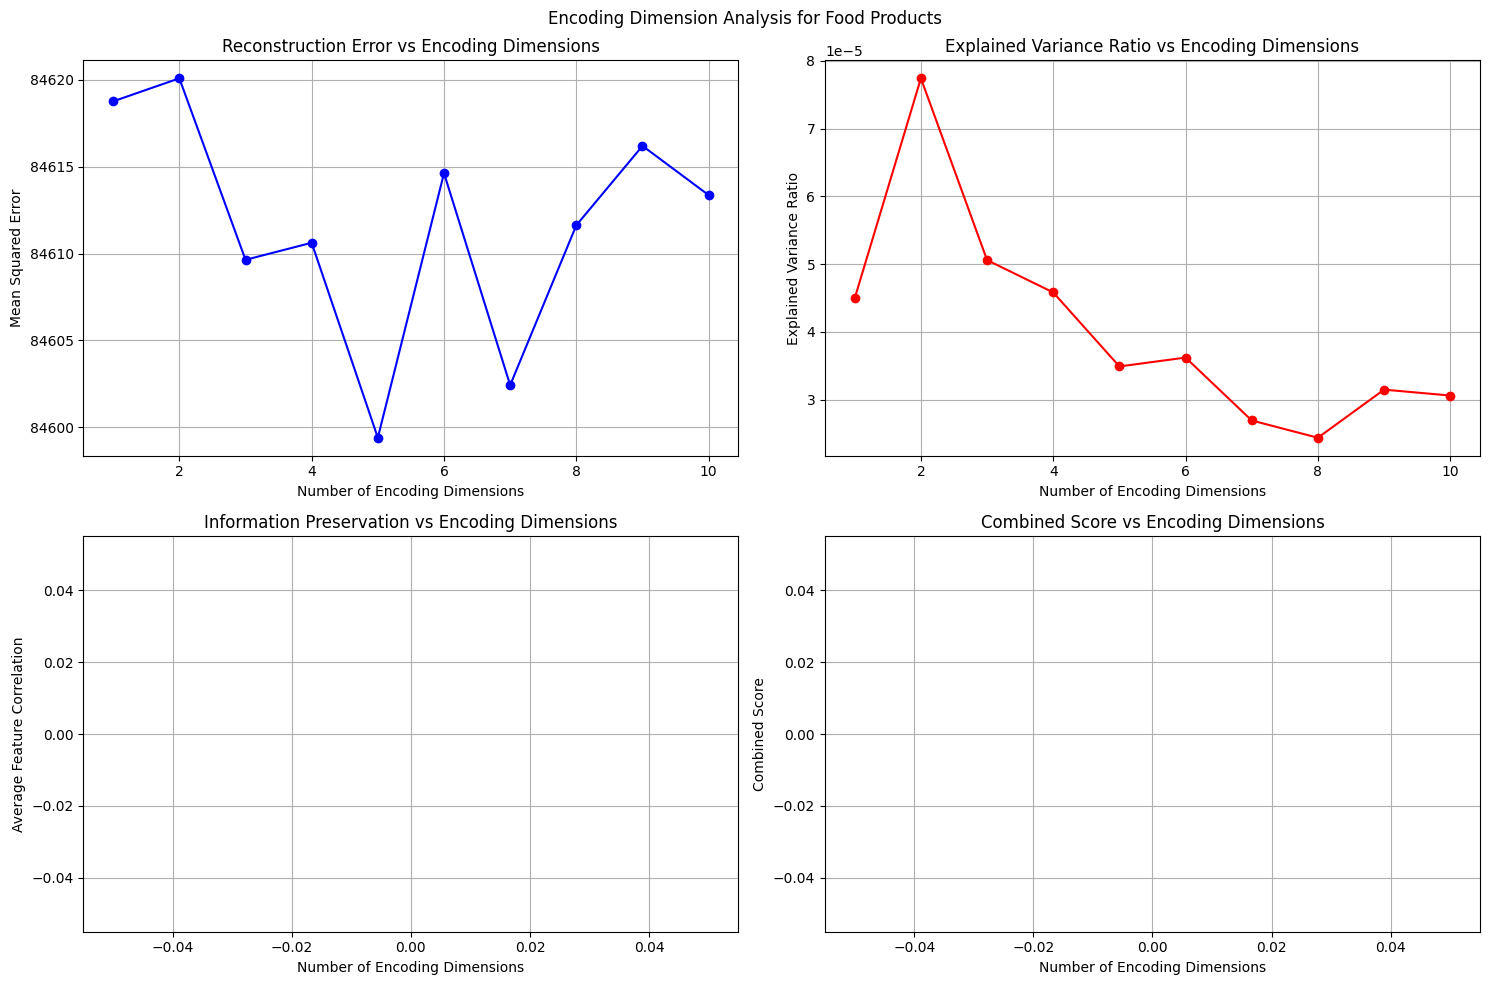


Encoding Dimension Analysis Results:
Best dimension based on reconstruction error: 5
Best dimension based on explained variance: 2
Best dimension based on information preservation: 1
Best dimension based on combined score: 1

Elbow Analysis:
Elbow point for reconstruction error: 5 dimensions
Elbow point for explained variance: 2 dimensions

Recommended number of encoding dimensions: 5
This recommendation is based on:
1. The elbow method for reconstruction error
2. The elbow method for explained variance
3. The combined score of all metrics


In [10]:
# Autoencoders
# Take a sample of your data
sample_size = 10000
df_sample = df_cleaned.sample(n=sample_size, random_state=42)

# Analyze different encoding dimensions
analyze_encoding_dimensions(
    data=df_sample.values,
    max_dim=10,  # Test dimensions from 1 to 10
    title="Encoding Dimension Analysis for Food Products"
)

In [ ]:
# After running the autoencoder
encoder, encoded_data, reconstructed_data, metrics = autoencoder_clustering(
    data=df_sample.values,
    encoding_dim=5
)

plot_autoencoder_advanced_analysis(
    encoded_data=encoded_data,
    original_data=df_sample.values,
    reconstructed_data=reconstructed_data,
    feature_names=df_sample.columns.tolist(),
    title="Advanced Autoencoder Analysis of Food Products"
)

kmeans, labels, kmeans_metrics = kmeans_clustering(encoded_data)

In [23]:
# Hierarchical clustering


### Cluster evaluation and comparison

In [24]:
# Compare clustering results using metrics (Silhouette score, Calinski-Harabasz index, Davies-Bouldin index)

In [25]:
# Visualize cluster comparisons (word clouds, ...)

In [26]:
# Analyse cluster characteristics and interpret results

### Visualization and Insights

In [27]:
# Various visualizations (cluster distribution plots, feature importance within clusters, pairplots with key features, heatmaps of cluster characteristics)


In [28]:
# Generate insights about food product groupings

In [29]:
# Indentify patterns and trends in the clusters

### Conclusions and recommendations

In [30]:
# Summarize findings


In [31]:
# Compare strengths and weaknesses of different clustering methods


In [32]:
# Provide recommendations for practical applications


In [33]:
#Suggest potential areas for futher analysis